# Homework Assignment: Geospatial Analysis of Hospitals in Peru

In [178]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }a
</style>
"""))

Se activan las librerías necesarias para el desarrollo de la actividad. Esto se obtiene de la clase de geopandas.

In [179]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import chardet

In [180]:
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point, LineString
import folium
from folium import Marker, GeoJson
from folium.plugins import MarkerCluster, HeatMap

In [181]:
# Enlace raw al archivo en GitHub
url = "https://github.com/luchoravar/Hospitals-Access-Peru/raw/main/code/data/IPRESS.csv"

# Descargar el archivo en binario
import requests
r = requests.get(url)
r.raise_for_status()
raw_data = r.content

# Intentar decodificar con latin1 (más permisivo que cp1252)
texto = raw_data.decode("latin1", errors="ignore")

# Guardar convertido a UTF-8
with open("IPRESS_utf8.csv", "w", encoding="utf-8") as f:
    f.write(texto)

# Ahora sí, abrir con pandas en UTF-8
df = pd.read_csv("IPRESS_utf8.csv")

print(df.head())
print(df.shape)

         Institución  Código Único Nombre del establecimiento  \
0            PRIVADO         16618                 SONRIE MAS   
1  GOBIERNO REGIONAL          7050                     AMBATO   
2  GOBIERNO REGIONAL            99  SANTA ISABEL DE YUMBATURO   
3            PRIVADO         19555               DENTOCAPLINA   
4               OTRO         18792  MEDICO DE FAMILIA MANTARA   

                                       Clasificación  \
0  CONSULTORIOS MEDICOS Y DE OTROS PROFESIONALES ...   
1                 PUESTOS DE SALUD O POSTAS DE SALUD   
2                 PUESTOS DE SALUD O POSTAS DE SALUD   
3  CONSULTORIOS MEDICOS Y DE OTROS PROFESIONALES ...   
4                 PUESTOS DE SALUD O POSTAS DE SALUD   

                                         Tipo Departamento Provincia  \
0  ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO         LIMA      LIMA   
1  ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO    CAJAMARCA   CUTERVO   
2  ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO       LORE

In [182]:
df.dtypes

,0
Institución,object
Código Único,int64
Nombre del establecimiento,object
Clasificación,object
Tipo,object
Departamento,object
Provincia,object
Distrito,object
UBIGEO,int64
Dirección,object


# Datos

Se tiene que subsetear los datos considerando como filtro: hospitales que estén operativos. Además de tener coordenadas válidas.

In [183]:
# se elabora una tabla de frecuencias para detectar las categorías de la variable Condición.
# Tabla de frecuencias absolutas
tabla_frec = df["Condición"].value_counts()

print(tabla_frec)

Condición
EN FUNCIONAMIENTO           20800
INOPERATIVO                    17
CIERRE TEMPORAL                 1
RESTRICCIÓN DE SERVICIOS        1
Name: count, dtype: int64


In [184]:
# con este código se subsetea los hospitales operativos.
df = df[df["Condición"] == "EN FUNCIONAMIENTO"]

df.shape
# se han retirado 19 casos, quedando 20800.

(20800, 33)

In [185]:
# ahora se debe filtrar por coordenadas válidas
# Filtrar hospitales con coordenadas válidas
df = df.dropna(subset=["NORTE", "ESTE"])   # elimina filas sin coordenadas
df = df[(df["NORTE"] != 0) & (df["ESTE"] != 0)]  # elimina 0,0

df.shape
# ahora la base de datos tiene 7939.

(7939, 33)

In [186]:
# finalmente se debe filtrar solo hospitales.
# Tabla de frecuencias absolutas
tabla_frec = df["Clasificación"].value_counts()

print(tabla_frec)

Clasificación
PUESTOS DE SALUD O POSTAS DE SALUD                                                         5907
CENTROS DE SALUD O CENTROS MEDICOS                                                         1193
CENTROS DE SALUD CON CAMAS DE INTERNAMIENTO                                                 331
HOSPITALES O CLINICAS DE ATENCION GENERAL                                                   212
HOSPITALES O CLINICAS DE ATENCION ESPECIALIZADA                                              63
POLICLINICOS                                                                                 62
CONSULTORIOS MEDICOS Y DE OTROS PROFESIONALES DE LA SALUD                                    60
PATOLOGIA CLINICA                                                                            26
INSTITUTOS DE SALUD ESPECIALIZADOS                                                           16
CENTROS MEDICOS ESPECIALIZADOS                                                               16
PUESTOS DE SALUD O POSTAS 

In [187]:
# finalmente se filtra solo a los hospitales.
df = df[df["Clasificación"].isin([
    "HOSPITALES O CLINICAS DE ATENCION GENERAL",
    "HOSPITALES O CLINICAS DE ATENCION ESPECIALIZADA"
])]

df.shape
# al final quedaron 275 filas (hospitales) y 33 variables.


(275, 33)

Algunos casos en Ubigeo tienen 5 números en lugar de 6. Esto se debe a un error al importar, ya que elimina el carácter inicial para los casos que comienzan con un 0. Agregaremos un 0 al principio para aquellos casos con menos de 6 números.

In [188]:
df['UBIGEO'] = df['UBIGEO'].astype(str)
df['UBIGEO'] = df['UBIGEO'].str.zfill(6)

In [189]:
df.head( 5 )
# ahora ya todos tienen seis dígitos

df.shape

(275, 33)

In [190]:
# vamos a crear un respaldo de los datos, que se empleará en el Task 2.
df_2 = df

In [191]:
df_2.shape

(275, 33)

Hasta aqui la base de datos está lista para el merge con maps. Ahora vamos a trabajar con Task 1.

# Task 1: Static Maps — Hospital Count by District

Load the district shapefile of Peru (link above).

In [192]:
import geopandas as gpd
!git clone https://github.com/luchoravar/Hospitals-Access-Peru.git
maps = gpd.read_file("Hospitals-Access-Peru/code/data/Distritos/DISTRITOS.shp")
print(maps.head())

fatal: destination path 'Hospitals-Access-Peru' already exists and is not an empty directory.
  IDDPTO DEPARTAMEN IDPROV    PROVINCIA  IDDIST                DISTRITO  \
0     10    HUANUCO   1009  PUERTO INCA  100902         CODO DEL POZUZO   
1     10    HUANUCO   1009  PUERTO INCA  100904             TOURNAVISTA   
2     25    UCAYALI   2503   PADRE ABAD  250305  ALEXANDER VON HUMBOLDT   
3     25    UCAYALI   2503   PADRE ABAD  250302                 IRAZOLA   
4     25    UCAYALI   2503   PADRE ABAD  250304                 NESHUYA   

                  CAPITAL CODCCPP  AREA FUENTE  \
0         CODO DEL POZUZO    0001     1   INEI   
1             TOURNAVISTA    0001     1   INEI   
2  ALEXANDER VON HUMBOLDT    0001     1   INEI   
3           SAN ALEJANDRO    0001     1   INEI   
4            MONTE ALEGRE    0001     1   INEI   

                                            geometry  
0  POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...  
1  POLYGON ((-74.64136 -8.82302, -74.64036 -

In [193]:
type(maps)

geopandas.geodataframe.GeoDataFrame

In [194]:
maps

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,IDDIST,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,SAN ALEJANDRO,0001,1,INEI,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,MONTE ALEGRE,0001,1,INEI,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."
...,...,...,...,...,...,...,...,...,...,...,...
1868,10,HUANUCO,1006,LEONCIO PRADO,100608,CASTILLO GRANDE,CASTILLO GRANDE,0001,1,INEI,"POLYGON ((-76.08083 -9.13017, -76.08026 -9.130..."
1869,10,HUANUCO,1006,LEONCIO PRADO,100609,PUEBLO NUEVO,PUEBLO NUEVO,0001,1,INEI,"POLYGON ((-75.88828 -9.00906, -75.88756 -9.010..."
1870,10,HUANUCO,1006,LEONCIO PRADO,100610,SANTO DOMINGO DE ANDA,PACAE,0001,1,INEI,"POLYGON ((-75.91141 -8.88593, -75.91182 -8.886..."
1871,21,PUNO,2111,SAN ROMAN,211105,SAN MIGUEL,SAN MIGUEL,0001,1,INEI,"POLYGON ((-70.13203 -15.33382, -70.12355 -15.3..."


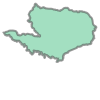

In [195]:
# Plot 1 district (its a collection of points)
maps['geometry'].iloc[6]

In [196]:
#Check unique values

maps['IDDIST'].is_unique

True

In [197]:
# Select only relevant columns
maps = maps[['IDDIST', 'geometry']]
maps = maps.rename({'IDDIST':'UBIGEO'}, axis =1 )
maps

,UBIGEO,geometry
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,250305,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,250302,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,250304,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."
...,...,...
1868,100608,"POLYGON ((-76.08083 -9.13017, -76.08026 -9.130..."
1869,100609,"POLYGON ((-75.88828 -9.00906, -75.88756 -9.010..."
1870,100610,"POLYGON ((-75.91141 -8.88593, -75.91182 -8.886..."
1871,211105,"POLYGON ((-70.13203 -15.33382, -70.12355 -15.3..."


In [198]:
maps.dtypes

,0
UBIGEO,object
geometry,geometry


In [199]:
# Object or srting to int

maps['UBIGEO'] = maps['UBIGEO'].astype(str).astype(int)
maps

,UBIGEO,geometry
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,250305,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,250302,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,250304,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."
...,...,...
1868,100608,"POLYGON ((-76.08083 -9.13017, -76.08026 -9.130..."
1869,100609,"POLYGON ((-75.88828 -9.00906, -75.88756 -9.010..."
1870,100610,"POLYGON ((-75.91141 -8.88593, -75.91182 -8.886..."
1871,211105,"POLYGON ((-70.13203 -15.33382, -70.12355 -15.3..."


In [200]:
# Ensure the dataset is in WGS-84 (EPSG:4326)
maps = maps.to_crs(epsg=4326)
maps.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

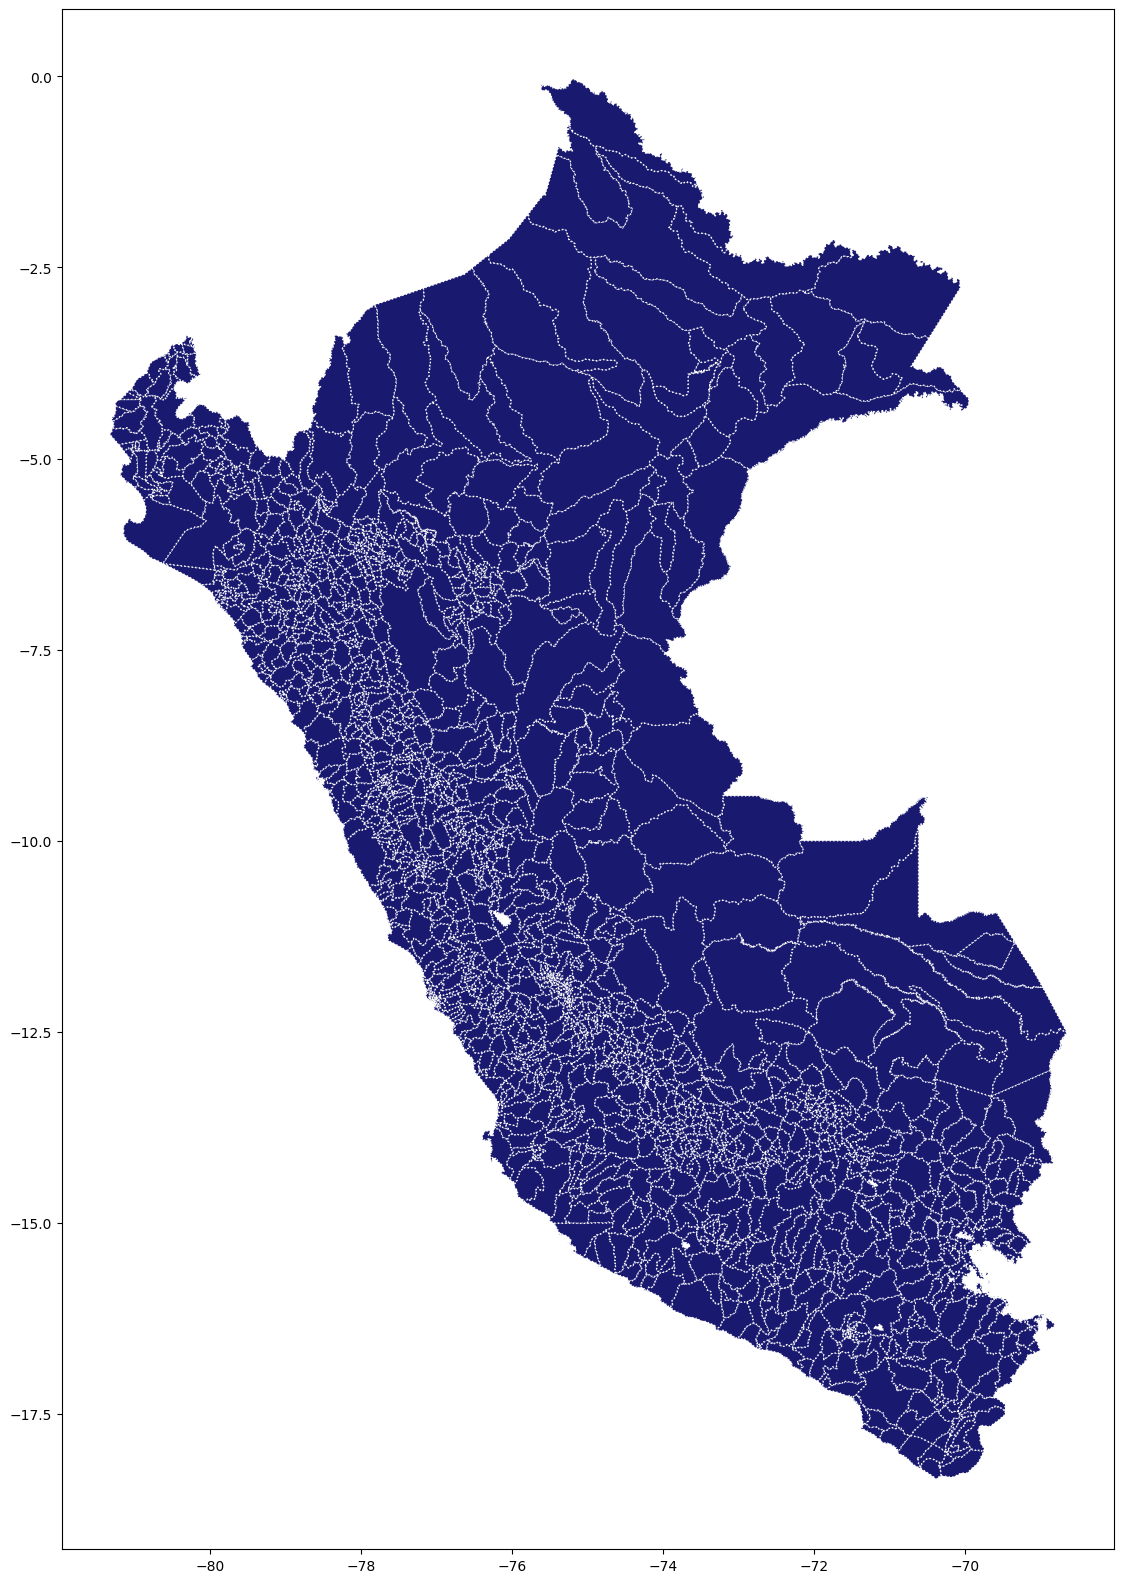

In [201]:
# Plot using geopandas

#figure and axis
fig, ax = plt.subplots(figsize=(20, 20))

maps.plot(  ax=ax, color='midnightblue', linestyle='dotted',
            edgecolor='white' )
plt.show()

## Unir los datos & Shapefile

El siguiente código sirve para elaborar una tabla de frecuencias con la variable UBIGEO. Esto permitirá conocer cuantos hospitales hay por cada distrito.

In [202]:
# Tabla de frecuencias de UBIGEO
tabla_frecuencias_ubigeo = df['UBIGEO'].value_counts().reset_index()

# Renombrar columnas
tabla_frecuencias_ubigeo.columns = ['UBIGEO', 'Frecuencia']

# Ordenar por UBIGEO (opcional)
tabla_frecuencias_ubigeo = tabla_frecuencias_ubigeo.sort_values(by='UBIGEO')

print(tabla_frecuencias_ubigeo)

     UBIGEO  Frecuencia
5    010101           4
38   010201           2
127  010401           1
111  010601           1
153  010701           1
..      ...         ...
19   230101           2
93   230103           1
8    240101           4
2    250101           5
106  250105           1

[182 rows x 2 columns]


In [203]:
# Merge using left way

maps["UBIGEO"] = maps["UBIGEO"].astype(int)
tabla_frecuencias_ubigeo["UBIGEO"] = tabla_frecuencias_ubigeo["UBIGEO"].astype(int)

dataset = pd.merge(maps, tabla_frecuencias_ubigeo, how="left", on="UBIGEO")

dataset.head()

dataset.shape


(1873, 3)

In [204]:
# Frecuencias de la variable UBIGEO
dataset.head()

,UBIGEO,geometry,Frecuencia
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",NaN
1,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",NaN
2,250305,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742...",NaN
3,250302,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569...",NaN
4,250304,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446...",NaN


In [205]:
# se coloca el valor 0 a los UBIGEOS que tiene datos NaN
dataset["Frecuencia"] = dataset["Frecuencia"].fillna(0).astype(int)


With GeoPandas, create static maps showing the number of operational public hospitals per district:

In [206]:
dataset.head()

,UBIGEO,geometry,Frecuencia
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",0
1,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",0
2,250305,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742...",0
3,250302,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569...",0
4,250304,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446...",0


<Axes: >

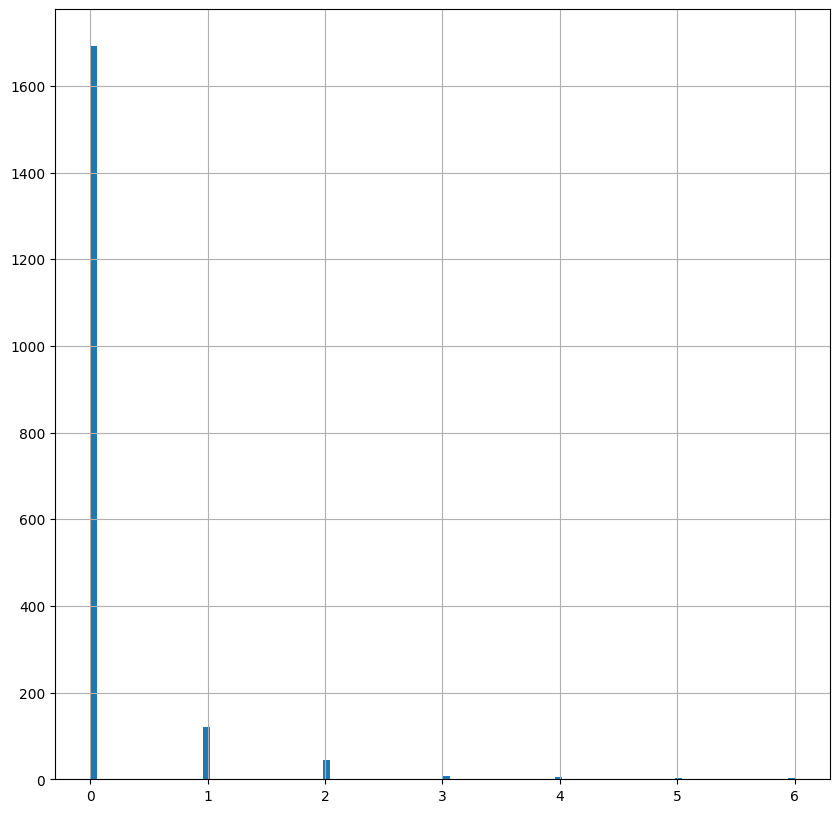

In [207]:
# First always check the distribution
fig, ax = plt.subplots(figsize=(10, 10))
dataset["Frecuencia"].hist(bins = 100)

#check the distribution of the variables BEFORE PLOTTING

In [208]:
type(dataset)

geopandas.geodataframe.GeoDataFrame

In [209]:
import geopandas as gpd

dataset = gpd.GeoDataFrame(dataset, geometry="geometry", crs="EPSG:4326")

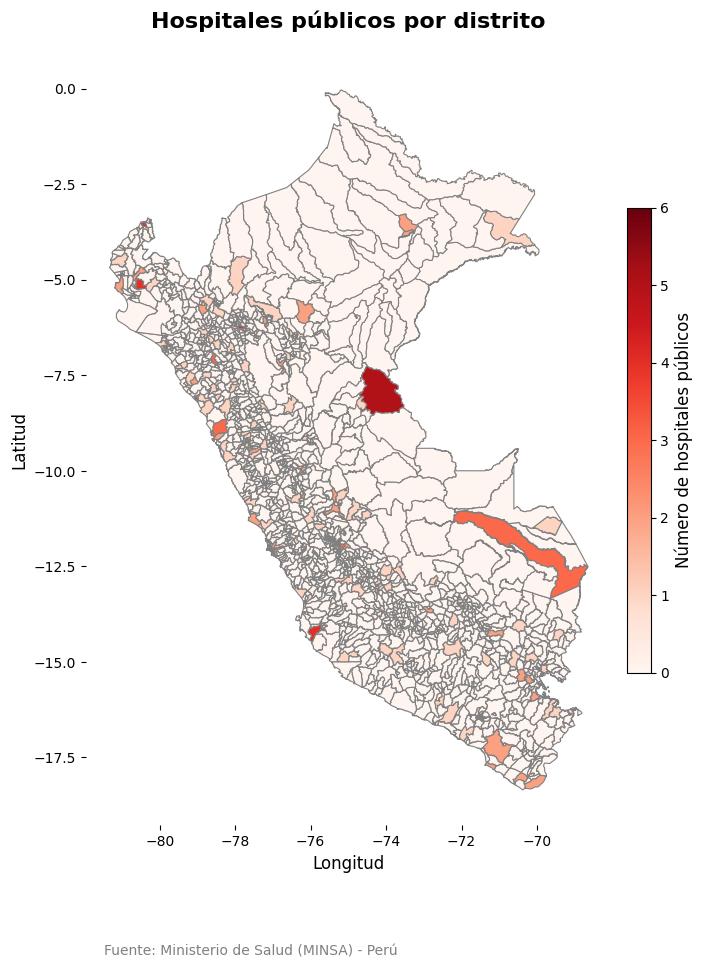

In [210]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Asegúrate de que dataset tiene la columna 'Frecuencia'
dataset = gpd.GeoDataFrame(dataset, geometry="geometry", crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot del mapa
dataset.plot(
    column='Frecuencia',   # 👈 usa el nombre correcto de tu columna
    cmap='Reds',
    linewidth=0.8,
    ax=ax,
    edgecolor='gray'
)

# Barra de color continua
sm = plt.cm.ScalarMappable(
    cmap='Reds',
    norm=plt.Normalize(vmin=dataset['Frecuencia'].min(), vmax=dataset['Frecuencia'].max())
)
sm._A = []
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Número de hospitales públicos", fontsize=12)

# Título
ax.set_title("Hospitales públicos por distrito", fontsize=16, fontweight='bold', pad=20)

# Etiquetas
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)

# Fuente
fig.text(
    0.5, -0.02, "Fuente: Ministerio de Salud (MINSA) - Perú",
    ha="center", fontsize=10, color="gray"
)

# Limpiar bordes
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()


## Map 2: Highlight districts with zero hospitals.

/tmp/ipython-input-2689538741.py:34: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left')
/tmp/ipython-input-2689538741.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower left')


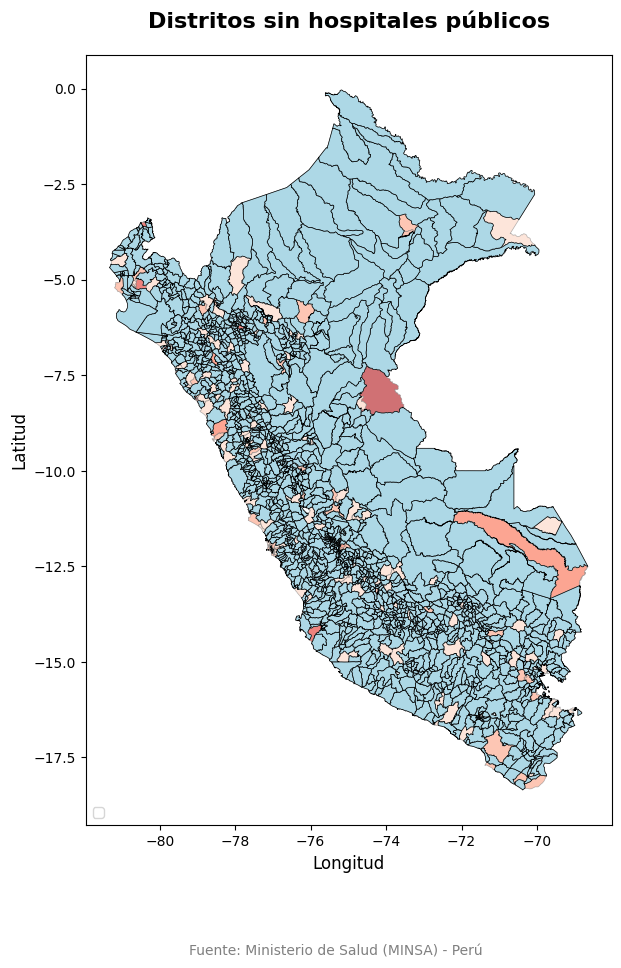

In [211]:
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Capa base (todos los distritos)
dataset.plot(
    column='Frecuencia',
    cmap='Reds',
    linewidth=0.5,
    ax=ax,
    edgecolor='gray',
    legend=False,
    alpha=0.6
)

# Capa resaltada (distritos con 0 hospitales)
dataset[dataset['Frecuencia'] == 0].plot(
    color='lightblue',   # 👈 puedes cambiar a amarillo, negro, etc.
    edgecolor='black',
    linewidth=0.5,
    ax=ax,
    label='0 hospitales'
)

# Título
ax.set_title("Distritos sin hospitales públicos", fontsize=16, fontweight='bold', pad=20)

# Etiquetas
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)

# Leyenda
ax.legend(loc='lower left')

# Fuente
fig.text(
    0.5, -0.02, "Fuente: Ministerio de Salud (MINSA) - Perú",
    ha="center", fontsize=10, color="gray"
)

plt.show()


## Map 3: Top 10 districts with the highest number of hospitals (distinct color scale).

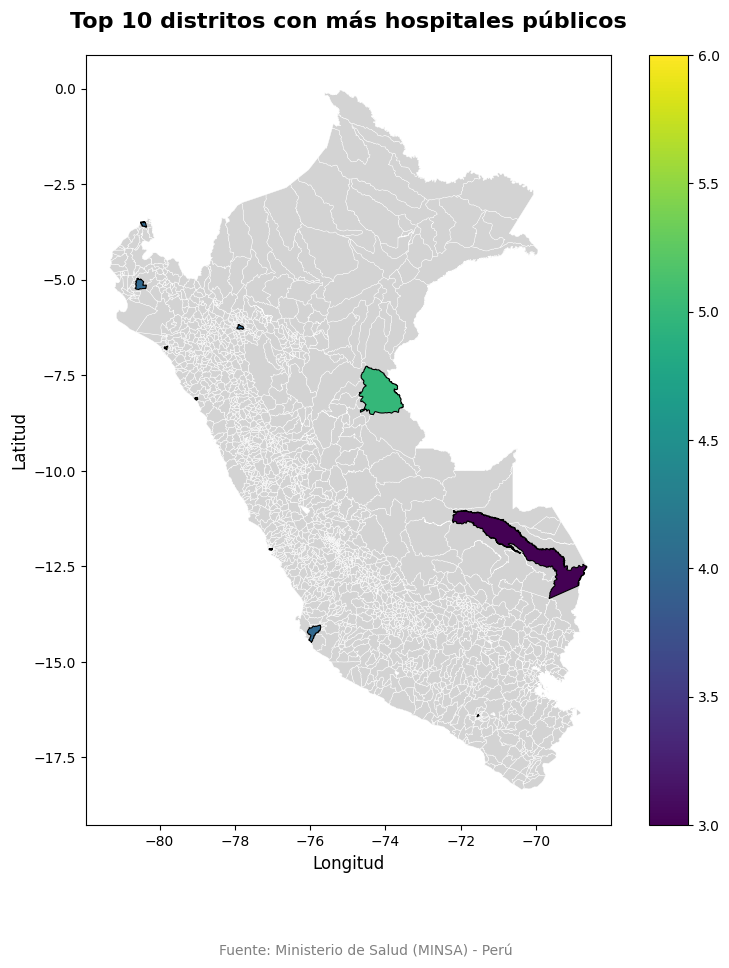

In [212]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Ordenamos por Frecuencia y sacamos el top 10
top10 = dataset.nlargest(10, 'Frecuencia')

fig, ax = plt.subplots(figsize=(10, 10))

# Capa base (todos los distritos en gris claro)
dataset.plot(
    color='lightgrey',
    edgecolor='white',
    linewidth=0.3,
    ax=ax
)

# Capa de los top 10 con otro colormap
top10.plot(
    column='Frecuencia',
    cmap='viridis',   # 👈 puedes cambiar a 'Blues', 'plasma', etc.
    linewidth=0.8,
    edgecolor='black',
    ax=ax,
    legend=True
)

# Título
ax.set_title("Top 10 distritos con más hospitales públicos", fontsize=16, fontweight='bold', pad=20)

# Etiquetas
ax.set_xlabel("Longitud", fontsize=12)
ax.set_ylabel("Latitud", fontsize=12)

# Fuente
fig.text(
    0.5, -0.02, "Fuente: Ministerio de Salud (MINSA) - Perú",
    ha="center", fontsize=10, color="gray"
)

plt.show()


# Task 2: Department-level Analysis

Aggregate at the department level.
Calculate the total number of operational hospitals in each department.

Ahora vamos a utilizar los datos "df_2" que se guardaron como respaldo.

In [213]:
df_2.dtypes

,0
Institución,object
Código Único,int64
Nombre del establecimiento,object
Clasificación,object
Tipo,object
Departamento,object
Provincia,object
Distrito,object
UBIGEO,object
Dirección,object


In [214]:
df_2.shape

(275, 33)

In [215]:
# con este código se subsetea los hospitales operativos.
df_2 = df_2[df_2["Condición"] == "EN FUNCIONAMIENTO"]

df_2.shape
# se han retirado 19 casos, quedando 20800.

(275, 33)

In [216]:
# Agrupar por departamento y contar hospitales
hosp_por_dep = df_2.groupby("Departamento", as_index=False).agg(
    Total_hospitales=("Nombre del establecimiento", "count")
)

hosp_por_dep = hosp_por_dep.sort_values(
    by="Total_hospitales",
    ascending=False
).reset_index(drop=True)

hosp_por_dep


,Departamento,Total_hospitales
0,LIMA,49
1,LA LIBERTAD,32
2,ANCASH,16
3,PUNO,14
4,JUNIN,13
5,AREQUIPA,12
6,PIURA,12
7,CAJAMARCA,11
8,AYACUCHO,11
9,SAN MARTIN,11


## Identify: The department with the highest number of hospitals and The department with the lowest number of hospitals.

Present the results with:
1. A summary table (sorted from highest to lowest). Que se encuentra arriba.

Para nuestro ejercicio:
- El departamento con mayor número de hospitales es Lima.
- El departamento con menor número de hospitales es Tumbes.

2. A bar chart (matplotlib or seaborn).

In [217]:
# !pip install seaborn

/tmp/ipython-input-684781549.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


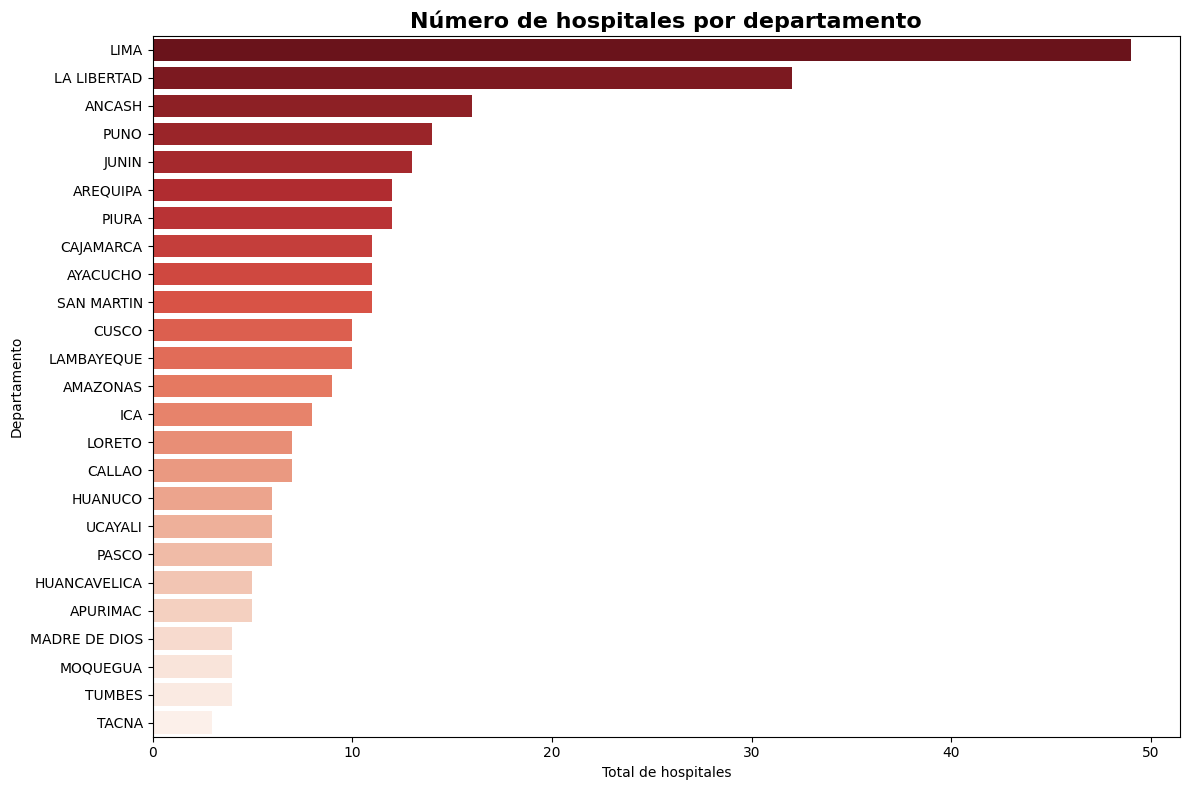

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(
    data=hosp_por_dep,
    x="Total_hospitales",
    y="Departamento",
    palette="Reds_r"
)

plt.title("Número de hospitales por departamento", fontsize=16, fontweight="bold")
plt.xlabel("Total de hospitales")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()


3. A department-level choropleth map (GeoPandas).

In [219]:
# como se está trabajando con departamento, lo que se tiene que hacer es utilizar los primeros dos dígitos del ubigeo.

df_2.head()

,Institución,Código Único,Nombre del establecimiento,Clasificación,Tipo,Departamento,Provincia,Distrito,UBIGEO,Dirección,...,Inicio de Actividad,Director Médico y/o Responsable de la Atención de Salud,Estado,Situación,Condición,Inspección,NORTE,ESTE,COTA,CAMAS
17,GOBIERNO REGIONAL,2941,CARLOS CORNEJO ROSELLO,HOSPITALES O CLINICAS DE ATENCION GENERAL,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,PUNO,AZANGARO,AZANGARO,210201,JR- FRANCISCO BOLOGNESI Nº 557,...,07/01/1977,WAGNER CACERES LOBATON,ACTIVADO,,EN FUNCIONAMIENTO,,-70.199339,-14.904143,3911.312,45.0
35,GOBIERNO REGIONAL,1516,CARHUAZ,HOSPITALES O CLINICAS DE ATENCION GENERAL,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,ANCASH,CARHUAZ,CARHUAZ,020601,JR. UNION S/N CARHUAZ,...,01/01/1900,MAGALY MIRTHA SUAREZ ACEVEDO,ACTIVADO,,EN FUNCIONAMIENTO,,-77.649385,-9.277484,2643.542,NaN
52,GOBIERNO REGIONAL,5263,"HOSPITAL PROVINCIAL ASCOPE ""ROSA SANCHEZ DE SA...",HOSPITALES O CLINICAS DE ATENCION GENERAL,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,LA LIBERTAD,ASCOPE,ASCOPE,130201,AVENIDA AV. GRAU S/N NÚMERO S/N DISTRITO ASCOP...,...,02/02/1986,FREDY LUIS CHUQUIPOMA LESCANO,ACTIVADO,,EN FUNCIONAMIENTO,,-79.101259,-7.714237,243.000,9.0
275,MINSA,5987,HOSPITAL MARIA AUXILIADORA,HOSPITALES O CLINICAS DE ATENCION ESPECIALIZADA,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,LIMA,LIMA,SAN JUAN DE MIRAFLORES,150133,CALLE MIGUEL IGLESIAS N°968,...,23/12/1983,JOSE FERNANDO NAVEDA VALLADARES,ACTIVADO,,EN FUNCIONAMIENTO,,-76.959102,-12.160577,NaN,374.0
339,ESSALUD,8685,HOSPITAL I ALBRECHT,HOSPITALES O CLINICAS DE ATENCION GENERAL,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,LA LIBERTAD,TRUJILLO,TRUJILLO,130101,AV JESUS DE NAZARETH S/N RESIDENCIAL ALBRECHT,...,11/06/1979,SALOMON CECILIO MENDIVIL BARRANTES,ACTIVADO,,EN FUNCIONAMIENTO,,-79.034930,-8.111071,NaN,28.0


In [220]:
# como se puede ver, se observa que producto de la importación, el código de UBIGEO ha sido afectado. Este codigo debería tener seis dígitos.
df_2['UBIGEO'] = df_2['UBIGEO'].astype(str)
df_2['UBIGEO'] = df_2['UBIGEO'].str.zfill(6)

In [221]:
df_2.head()
# ahora ya está configurado con seis dígitos.

,Institución,Código Único,Nombre del establecimiento,Clasificación,Tipo,Departamento,Provincia,Distrito,UBIGEO,Dirección,...,Inicio de Actividad,Director Médico y/o Responsable de la Atención de Salud,Estado,Situación,Condición,Inspección,NORTE,ESTE,COTA,CAMAS
17,GOBIERNO REGIONAL,2941,CARLOS CORNEJO ROSELLO,HOSPITALES O CLINICAS DE ATENCION GENERAL,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,PUNO,AZANGARO,AZANGARO,210201,JR- FRANCISCO BOLOGNESI Nº 557,...,07/01/1977,WAGNER CACERES LOBATON,ACTIVADO,,EN FUNCIONAMIENTO,,-70.199339,-14.904143,3911.312,45.0
35,GOBIERNO REGIONAL,1516,CARHUAZ,HOSPITALES O CLINICAS DE ATENCION GENERAL,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,ANCASH,CARHUAZ,CARHUAZ,020601,JR. UNION S/N CARHUAZ,...,01/01/1900,MAGALY MIRTHA SUAREZ ACEVEDO,ACTIVADO,,EN FUNCIONAMIENTO,,-77.649385,-9.277484,2643.542,NaN
52,GOBIERNO REGIONAL,5263,"HOSPITAL PROVINCIAL ASCOPE ""ROSA SANCHEZ DE SA...",HOSPITALES O CLINICAS DE ATENCION GENERAL,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,LA LIBERTAD,ASCOPE,ASCOPE,130201,AVENIDA AV. GRAU S/N NÚMERO S/N DISTRITO ASCOP...,...,02/02/1986,FREDY LUIS CHUQUIPOMA LESCANO,ACTIVADO,,EN FUNCIONAMIENTO,,-79.101259,-7.714237,243.000,9.0
275,MINSA,5987,HOSPITAL MARIA AUXILIADORA,HOSPITALES O CLINICAS DE ATENCION ESPECIALIZADA,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,LIMA,LIMA,SAN JUAN DE MIRAFLORES,150133,CALLE MIGUEL IGLESIAS N°968,...,23/12/1983,JOSE FERNANDO NAVEDA VALLADARES,ACTIVADO,,EN FUNCIONAMIENTO,,-76.959102,-12.160577,NaN,374.0
339,ESSALUD,8685,HOSPITAL I ALBRECHT,HOSPITALES O CLINICAS DE ATENCION GENERAL,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,LA LIBERTAD,TRUJILLO,TRUJILLO,130101,AV JESUS DE NAZARETH S/N RESIDENCIAL ALBRECHT,...,11/06/1979,SALOMON CECILIO MENDIVIL BARRANTES,ACTIVADO,,EN FUNCIONAMIENTO,,-79.034930,-8.111071,NaN,28.0


In [222]:
# En el código de UBIGEO, los primeros dos dígitos representan al departamento. Se tiene que extraer.

# UBIGEO sea string para extraer caracteres
df_2["UBIGEO"] = df_2["UBIGEO"].astype(str).str.zfill(6)

# Se crea nueva variable con los 2 primeros dígitos
df_2["UBIGEO_DEP"] = df_2["UBIGEO"].str[:2]

print(df_2[["UBIGEO", "UBIGEO_DEP"]].head())

# ya estan separados los primeros dos digitos.


     UBIGEO UBIGEO_DEP
17   210201         21
35   020601         02
52   130201         13
275  150133         15
339  130101         13


In [223]:
# vamos a utilizar el objeto maps del anterior ejercicio
maps

,UBIGEO,geometry
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975..."
1,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828..."
2,250305,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742..."
3,250302,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569..."
4,250304,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446..."
...,...,...
1868,100608,"POLYGON ((-76.08083 -9.13017, -76.08026 -9.130..."
1869,100609,"POLYGON ((-75.88828 -9.00906, -75.88756 -9.010..."
1870,100610,"POLYGON ((-75.91141 -8.88593, -75.91182 -8.886..."
1871,211105,"POLYGON ((-70.13203 -15.33382, -70.12355 -15.3..."


In [224]:
# de forma similar se tiene que extraer los primeros dos dígitos de UBIGEO

# Asegúrate de que UBIGEO sea string para extraer caracteres
maps["UBIGEO"] = maps["UBIGEO"].astype(str).str.zfill(6)

# Crear nueva variable con los 2 primeros dígitos
maps["UBIGEO_DEP"] = maps["UBIGEO"].str[:2]

print(maps[["UBIGEO", "UBIGEO_DEP"]].head())

# ya estan separados los primeros dos digitos.

   UBIGEO UBIGEO_DEP
0  100902         10
1  100904         10
2  250305         25
3  250302         25
4  250304         25


In [225]:
maps.head()

,UBIGEO,geometry,UBIGEO_DEP
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",10
1,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",10
2,250305,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742...",25
3,250302,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569...",25
4,250304,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446...",25


In [226]:
df_2.head()

,Institución,Código Único,Nombre del establecimiento,Clasificación,Tipo,Departamento,Provincia,Distrito,UBIGEO,Dirección,...,Director Médico y/o Responsable de la Atención de Salud,Estado,Situación,Condición,Inspección,NORTE,ESTE,COTA,CAMAS,UBIGEO_DEP
17,GOBIERNO REGIONAL,2941,CARLOS CORNEJO ROSELLO,HOSPITALES O CLINICAS DE ATENCION GENERAL,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,PUNO,AZANGARO,AZANGARO,210201,JR- FRANCISCO BOLOGNESI Nº 557,...,WAGNER CACERES LOBATON,ACTIVADO,,EN FUNCIONAMIENTO,,-70.199339,-14.904143,3911.312,45.0,21
35,GOBIERNO REGIONAL,1516,CARHUAZ,HOSPITALES O CLINICAS DE ATENCION GENERAL,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,ANCASH,CARHUAZ,CARHUAZ,020601,JR. UNION S/N CARHUAZ,...,MAGALY MIRTHA SUAREZ ACEVEDO,ACTIVADO,,EN FUNCIONAMIENTO,,-77.649385,-9.277484,2643.542,NaN,02
52,GOBIERNO REGIONAL,5263,"HOSPITAL PROVINCIAL ASCOPE ""ROSA SANCHEZ DE SA...",HOSPITALES O CLINICAS DE ATENCION GENERAL,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,LA LIBERTAD,ASCOPE,ASCOPE,130201,AVENIDA AV. GRAU S/N NÚMERO S/N DISTRITO ASCOP...,...,FREDY LUIS CHUQUIPOMA LESCANO,ACTIVADO,,EN FUNCIONAMIENTO,,-79.101259,-7.714237,243.000,9.0,13
275,MINSA,5987,HOSPITAL MARIA AUXILIADORA,HOSPITALES O CLINICAS DE ATENCION ESPECIALIZADA,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,LIMA,LIMA,SAN JUAN DE MIRAFLORES,150133,CALLE MIGUEL IGLESIAS N°968,...,JOSE FERNANDO NAVEDA VALLADARES,ACTIVADO,,EN FUNCIONAMIENTO,,-76.959102,-12.160577,NaN,374.0,15
339,ESSALUD,8685,HOSPITAL I ALBRECHT,HOSPITALES O CLINICAS DE ATENCION GENERAL,ESTABLECIMIENTO DE SALUD CON INTERNAMIENTO,LA LIBERTAD,TRUJILLO,TRUJILLO,130101,AV JESUS DE NAZARETH S/N RESIDENCIAL ALBRECHT,...,SALOMON CECILIO MENDIVIL BARRANTES,ACTIVADO,,EN FUNCIONAMIENTO,,-79.034930,-8.111071,NaN,28.0,13


In [227]:
# para elaborar la tabla se tiene que elaborar una tabla de frecuencias de la variable UBIGEO_DEP

# Tabla de frecuencias de UBIGEO
tabla_frecuencias_ubigeo_dep = df_2["UBIGEO_DEP"].value_counts().reset_index()

# Renombrar columnas
tabla_frecuencias_ubigeo_dep.columns = ['UBIGEO_DEP', 'Frecuencia']

print(tabla_frecuencias_ubigeo_dep)

   UBIGEO_DEP  Frecuencia
0          15          49
1          13          32
2          02          16
3          21          14
4          12          13
5          04          12
6          20          12
7          05          11
8          22          11
9          06          11
10         08          10
11         14          10
12         01           9
13         11           8
14         07           7
15         16           7
16         10           6
17         25           6
18         19           6
19         09           5
20         03           5
21         24           4
22         17           4
23         18           4
24         23           3


In [228]:
# merge - unión de los datos
# Merge using left way

maps["UBIGEO_DEP"] = maps["UBIGEO_DEP"].astype(int)
tabla_frecuencias_ubigeo_dep["UBIGEO_DEP"] = tabla_frecuencias_ubigeo_dep["UBIGEO_DEP"].astype(int)

dataset_2 = pd.merge(maps, tabla_frecuencias_ubigeo_dep, how="left", on="UBIGEO_DEP")

dataset_2.head()

,UBIGEO,geometry,UBIGEO_DEP,Frecuencia
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",10,6
1,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",10,6
2,250305,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742...",25,6
3,250302,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569...",25,6
4,250304,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446...",25,6


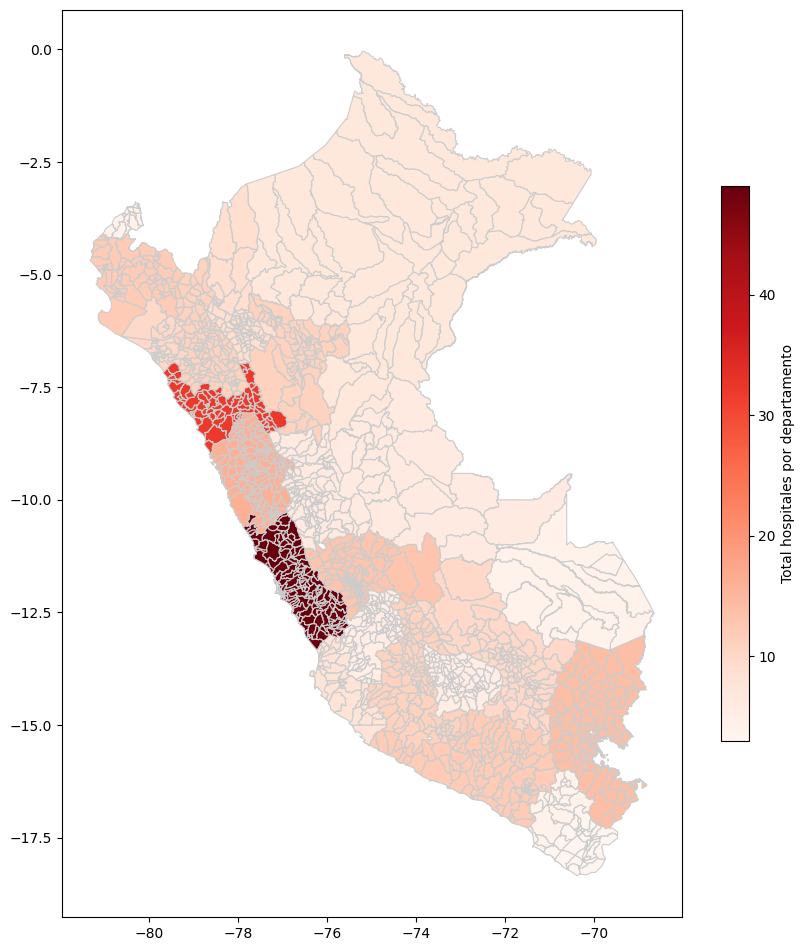

In [229]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

fig, ax = plt.subplots(1, 1, figsize=(10, 12))

dataset_2.plot(
    column="Frecuencia",
    cmap="Reds",
    linewidth=0.8,
    edgecolor="0.8",
    legend=True,
    legend_kwds={
        "label": "Total hospitales por departamento",
        "orientation": "vertical",
        "shrink": 0.6
    },
    ax=ax
)

# Ajustar ticks de la barra de color
cbar = ax.get_figure().get_axes()[-1]  # último eje = colorbar
cbar.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Task 3: Proximity Analysis (using Population Centers)

Regions to analyze:

Lima
Loreto

Indicaciones:

Methodology:

From Population Centers, compute the centroid of each locality (or use the provided geometry centroids).
For each centroid, calculate the number of operational hospitals within a 10 km buffer.
Identify (per region):
The population center with the fewest hospitals nearby (isolation).
The population center with the most hospitals nearby (concentration).
Plot with folium:
The selected population center (centroid).
The 10 km buffer (circle).
All hospitals inside the buffer.
Notes:

Ensure all layers use CRS EPSG:4326 (or project to EPSG:32718 for metric 10 km buffers and then reproject back to EPSG:4326 for visualization).
Document any cleaning steps (duplicate removal, invalid coordinates).

In [230]:

# En primer lugar, se tiene que abrir el shape file de Centro Poblado.
url="https://github.com/luchoravar/Hospitals-Access-Peru/raw/main/code/data/CCPP_0.zip"
CCPP = gpd.read_file(f"zip+{url}")
print(CCPP.head())



   OBJECTID   NOM_POBLAD FUENTE      CÓDIGO CAT_POBLAD      DIST     PROV  \
0         1   PANDISHARI   INEI  2502010002      OTROS  RAYMONDI  ATALAYA   
1         2      CHICOSA   INEI  2502010003      OTROS  RAYMONDI  ATALAYA   
2         3         RAYA    IGN  2502010004      OTROS  RAYMONDI  ATALAYA   
3         4  PENSILVANIA   INEI  2502010005      OTROS  RAYMONDI  ATALAYA   
4         5  PONTE VEDRA   INEI  2502010006    CASERÍO  RAYMONDI  ATALAYA   

       DEP CÓD_INT             CATEGORIA         X         Y     N_BUSQDA  \
0  UCAYALI    2050  Centro Poblado Menor -74.06462 -10.37129   PANDISHARI   
1  UCAYALI    2050  Centro Poblado Menor -74.06153 -10.37852      CHICOSA   
2  UCAYALI    2350  Centro Poblado Menor -72.94118 -10.33043         RAYA   
3  UCAYALI    2050  Centro Poblado Menor -74.05988 -10.40401  PENSILVANIA   
4  UCAYALI    2050  Centro Poblado Menor -74.03788 -10.41809  PONTE VEDRA   

                      geometry  
0  POINT (-74.06462 -10.37129)  
1  POINT

In [231]:
CCPP.head()

,OBJECTID,NOM_POBLAD,FUENTE,CÓDIGO,CAT_POBLAD,DIST,PROV,DEP,CÓD_INT,CATEGORIA,X,Y,N_BUSQDA,geometry
0,1,PANDISHARI,INEI,2502010002,OTROS,RAYMONDI,ATALAYA,UCAYALI,2050,Centro Poblado Menor,-74.06462,-10.37129,PANDISHARI,POINT (-74.06462 -10.37129)
1,2,CHICOSA,INEI,2502010003,OTROS,RAYMONDI,ATALAYA,UCAYALI,2050,Centro Poblado Menor,-74.06153,-10.37852,CHICOSA,POINT (-74.06153 -10.37852)
2,3,RAYA,IGN,2502010004,OTROS,RAYMONDI,ATALAYA,UCAYALI,2350,Centro Poblado Menor,-72.94118,-10.33043,RAYA,POINT (-72.94118 -10.33043)
3,4,PENSILVANIA,INEI,2502010005,OTROS,RAYMONDI,ATALAYA,UCAYALI,2050,Centro Poblado Menor,-74.05988,-10.40401,PENSILVANIA,POINT (-74.05988 -10.40401)
4,5,PONTE VEDRA,INEI,2502010006,CASERÍO,RAYMONDI,ATALAYA,UCAYALI,2050,Centro Poblado Menor,-74.03788,-10.41809,PONTE VEDRA,POINT (-74.03787 -10.41809)


In [232]:
maps.head()

,UBIGEO,geometry,UBIGEO_DEP
0,100902,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",10
1,100904,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",10
2,250305,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742...",25
3,250302,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569...",25
4,250304,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446...",25


In [233]:
import geopandas as gpd
import folium

In [234]:
# nos tenemos que asegurar que los datos estén en EPSG: 4326
# Asegurar que ambos datasets estén en EPSG:4326
CCPP = CCPP.to_crs("EPSG:4326")
maps = maps.to_crs("EPSG:4326")

Se tiene que filtrar las regiones de interés
 - Lima
 - Loreto


In [235]:
CCPP.dtypes
# se tiene que utilizar la variable DEP

,0
OBJECTID,int64
NOM_POBLAD,object
FUENTE,object
CÓDIGO,object
CAT_POBLAD,object
DIST,object
PROV,object
DEP,object
CÓD_INT,object
CATEGORIA,object


In [236]:
maps.dtypes
# se tiene que utilizar la variable UBIGEO_DEP

,0
UBIGEO,object
geometry,geometry
UBIGEO_DEP,int64


In [237]:
# para filtralos se utilizará el Código de UBIGEO:
# 1501: Lima Metropolitana
# 1601: Provincia de Maynas (capital de Iquitos) en el departamento de Loreto
centros_sel = CCPP[CCPP["DEP"].isin(["LIMA", "LORETO"])].copy()
hosp_sel = maps[maps["UBIGEO_DEP"].isin([15,16])].copy()  # solo hospitales operativos


In [238]:
centros_sel["DEP"].value_counts()

,count
DEP,
LIMA,7615
LORETO,3447


In [239]:
hosp_sel["UBIGEO_DEP"].value_counts()

,count
UBIGEO_DEP,
15,171
16,53


In [240]:
# Reproyectar a métrico (UTM 18S Perú EPSG:32718)
centros_sel = centros_sel.to_crs("EPSG:32718")
hosp_sel = hosp_sel.to_crs("EPSG:32718")

In [241]:
# Calcular buffers de 10 km para cada centro poblado
centros_sel["buffer_10km"] = centros_sel.geometry.buffer(10000)

In [242]:
# Contar hospitales dentro de cada buffer
hospitales_count = []
for idx, row in centros_sel.iterrows():
    buffer = row["buffer_10km"]
    dentro = hosp_sel[hosp_sel.intersects(buffer)]
    hospitales_count.append(len(dentro))

centros_sel["Hosp_10km"] = hospitales_count

In [243]:
# Identificar aislamiento y concentración
aislado = centros_sel.loc[centros_sel["Hosp_10km"].idxmin()]
concentrado = centros_sel.loc[centros_sel["Hosp_10km"].idxmax()]

print("Centro poblado más aislado:", aislado["NOM_POBLAD"], "con", aislado["Hosp_10km"], "hospitales en 10 km")
print("Centro poblado más concentrado:", concentrado["NOM_POBLAD"], "con", concentrado["Hosp_10km"], "hospitales en 10 km")

Centro poblado más aislado: RIEGOPAMPA con 0 hospitales en 10 km
Centro poblado más concentrado: LA VICTORIA con 28 hospitales en 10 km


In [244]:
# Reproyectar a EPSG:4326 para visualización
centros_sel = centros_sel.to_crs("EPSG:4326")
hosp_sel = hosp_sel.to_crs("EPSG:4326")

In [245]:
# Visualizar con Folium
m = folium.Map(location=[-12.0464, -77.0428], zoom_start=6)  # centrado en Perú

In [246]:
# Crear una nueva columna con los centroides
hosp_sel["centroid"] = hosp_sel.geometry.centroid

# Ahora puedes iterar con los centroides
for _, row in hosp_sel.iterrows():
    folium.CircleMarker(
        location=[row.centroid.y, row.centroid.x],
        radius=3,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.7
    ).add_to(m)


/tmp/ipython-input-1327423648.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hosp_sel["centroid"] = hosp_sel.geometry.centroid


In [247]:
hosp_sel.head()

,UBIGEO,geometry,UBIGEO_DEP,centroid
10,160601,"POLYGON ((-74.93183 -7.15278, -74.92994 -7.153...",16,POINT (-75.34938 -7.78112)
327,150304,"POLYGON ((-77.08978 -10.46946, -77.08743 -10.4...",15,POINT (-77.10893 -10.52169)
346,160603,"POLYGON ((-74.63721 -7.5718, -74.63129 -7.5793...",16,POINT (-74.91432 -7.8794)
347,151011,"POLYGON ((-75.88359 -12.48887, -75.88172 -12.4...",15,POINT (-75.84598 -12.58427)
350,151027,"POLYGON ((-76.19441 -12.44392, -76.19354 -12.4...",15,POINT (-76.18609 -12.49298)


In [248]:
# Añadir centro aislado
folium.Marker(
    location=[aislado.geometry.y, aislado.geometry.x],
    popup=f"Aislado: {aislado['NOM_POBLAD']} ({aislado['Hosp_10km']} hospitales)",
    icon=folium.Icon(color="blue", icon="info-sign")
).add_to(m)

folium.Circle(
    location=[aislado.geometry.y, aislado.geometry.x],
    radius=10000,  # 10 km
    color="blue",
    fill=False
).add_to(m)

In [249]:
# Añadir centro concentrado
folium.Marker(
    location=[concentrado.geometry.y, concentrado.geometry.x],
    popup=f"Concentrado: {concentrado['NOM_POBLAD']} ({concentrado['Hosp_10km']} hospitales)",
    icon=folium.Icon(color="green", icon="info-sign")
).add_to(m)

folium.Circle(
    location=[concentrado.geometry.y, concentrado.geometry.x],
    radius=10000,
    color="green",
    fill=False
).add_to(m)

In [250]:
# Guardar mapa
m.save("proximidad_hospitales.html")

# 3) Interactive Mapping with Folium

## Task 1: National Choropleth (District Level)

In [251]:
#Creamos GeoDataFrame de hospitales  ----------

hospitales_gdf = gpd.GeoDataFrame(
    df.copy(),
    geometry=gpd.points_from_xy(df["ESTE"], df["NORTE"]),
    crs="EPSG:32718"   # cambiamos coordenadas
)

# Reproyectar hospitales a EPSG:4326
hospitales_4326 = hospitales_gdf.to_crs(epsg=4326)

#Choropleth (distrito) + MarkerCluster ----------

dataset_choro = dataset.copy()
dataset_choro["UBIGEO"] = dataset_choro["UBIGEO"].astype(str)

# Convertir a geojson
geojson_distritos = dataset_choro.to_json()

# Crear mapa base centrado en Perú
m_choro = folium.Map(location=[-9.19, -75.02], zoom_start=5, tiles="CartoDB positron")


In [252]:
# Count de hospitales por distrito
folium.Choropleth(
    geo_data=geojson_distritos,
    name="choropleth",
    data=dataset_choro,
    columns=["UBIGEO", "Frecuencia"],
    key_on="feature.properties.UBIGEO",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name="Número de hospitales por distrito",
    nan_fill_color="white"
).add_to(m_choro)

In [253]:
# construimos un GeoJson con tooltip
folium.GeoJson(
    data=geojson_distritos,
    name="Distritos (tooltip)",
    tooltip=folium.GeoJsonTooltip(
        fields=["UBIGEO", "Frecuencia"],
        aliases=["UBIGEO:", "N° hospitales:"],
        localize=True
    ),
    style_function=lambda x: {'fillOpacity':0, 'color': 'none'}
).add_to(m_choro)

In [254]:
# Añadimos MarkerCluster para todos los hospitales
marker_cluster = MarkerCluster(name="Hospitales (cluster)").add_to(m_choro)
for _, row in hospitales_4326.iterrows():
    popup_text = (f"{row.get('Nombre del establecimiento','Hospital')}<br>"
                  f"Departamento: {row.get('Departamento','')}, Distrito UBIGEO: {row.get('UBIGEO','')}")
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=popup_text,
        icon=folium.Icon(color="red", icon="plus-sign")
    ).add_to(marker_cluster)

In [266]:

# Guardar mapa choropleth
m_choro.save("choropleth_hospitales_distrito.html")
print("Saved: choropleth_hospitales_distrito.html")

Saved: choropleth_hospitales_distrito.html


## Task 2: Proximity Visualization — Lima & Loreto

In [256]:
## Cómo avanzamos la tarea por partes, aquí vuelvo a importar las librerías que vamos a utilizar
import geopandas as gpd
import folium
from folium import Circle, Marker, CircleMarker
from shapely.geometry import Point


In [257]:
# Importamos directamente el archivo de CCPP dede el github donde se va a presentar la tarea
url = "https://github.com/luchoravar/Hospitals-Access-Peru/raw/main/code/data/CCPP_0.zip"
CCPP = gpd.read_file(f"zip+{url}")


In [258]:
# Asegurar que ambos datasets estén en EPSG:4326, el sistema de coordenadas
CCPP = CCPP.to_crs("EPSG:4326")
maps = maps.to_crs("EPSG:4326")

# Filtramos los dfs para solamente trabajar con Lima y Loreto
centros_sel = CCPP[CCPP["DEP"].isin(["LIMA", "LORETO"])].copy()
hosp_sel = maps[maps["UBIGEO_DEP"].isin([15, 16])].copy()


In [259]:
# Reproyectamos a métrico (UTM 18S Perú EPSG:32718)
centros_sel = centros_sel.to_crs("EPSG:32718")
hosp_sel = hosp_sel.to_crs("EPSG:32718")

# Calculamos  buffers de 10 km para cada centro poblado
centros_sel["buffer_10km"] = centros_sel.geometry.buffer(10000)

# Contar hospitales dentro de cada buffer
hospitales_count = []
for idx, row in centros_sel.iterrows():
    buffer = row["buffer_10km"]
    dentro = hosp_sel[hosp_sel.intersects(buffer)]
    hospitales_count.append(len(dentro))

centros_sel["Hosp_10km"] = hospitales_count



In [260]:


# Separar Lima y Loreto
centros_lima = centros_sel[centros_sel["DEP"] == "LIMA"].copy()
centros_loreto = centros_sel[centros_sel["DEP"] == "LORETO"].copy()

# Identificar más aislado (mínimo) y más concentrado (máximo) en cada región
aislado_lima = centros_lima.loc[centros_lima["Hosp_10km"].idxmin()]
concentrado_lima = centros_lima.loc[centros_lima["Hosp_10km"].idxmax()]
aislado_loreto = centros_loreto.loc[centros_loreto["Hosp_10km"].idxmin()]
concentrado_loreto = centros_loreto.loc[centros_loreto["Hosp_10km"].idxmax()]

print("RESULTADOS:")
print(f"LIMA aislado: {aislado_lima['NOM_POBLAD']} ({aislado_lima['Hosp_10km']} hospitales)")
print(f"LIMA concentrado: {concentrado_lima['NOM_POBLAD']} ({concentrado_lima['Hosp_10km']} hospitales)")
print(f"LORETO aislado: {aislado_loreto['NOM_POBLAD']} ({aislado_loreto['Hosp_10km']} hospitales)")
print(f"LORETO concentrado: {concentrado_loreto['NOM_POBLAD']} ({concentrado_loreto['Hosp_10km']} hospitales)")



RESULTADOS:
LIMA aislado: RIEGOPAMPA (0 hospitales)
LIMA concentrado: LA VICTORIA (28 hospitales)
LORETO aislado: PUEBLO NUEVO (1 hospitales)
LORETO concentrado: SAN ANTONIO DE GALLITO (6 hospitales)


In [261]:

# Extraer hospitales por buffer
hosp_aislado_lima = hosp_sel[hosp_sel.intersects(aislado_lima["buffer_10km"])]
hosp_concentrado_lima = hosp_sel[hosp_sel.intersects(concentrado_lima["buffer_10km"])]
hosp_aislado_loreto = hosp_sel[hosp_sel.intersects(aislado_loreto["buffer_10km"])]
hosp_concentrado_loreto = hosp_sel[hosp_sel.intersects(concentrado_loreto["buffer_10km"])]

# Reproyectar a EPSG:4326 para visualización en Folium
centros_sel = centros_sel.to_crs("EPSG:4326")
hosp_sel = hosp_sel.to_crs("EPSG:4326")
hosp_aislado_lima = hosp_aislado_lima.to_crs("EPSG:4326")
hosp_concentrado_lima = hosp_concentrado_lima.to_crs("EPSG:4326")
hosp_aislado_loreto = hosp_aislado_loreto.to_crs("EPSG:4326")
hosp_concentrado_loreto = hosp_concentrado_loreto.to_crs("EPSG:4326")


In [262]:

# Crear mapa centrado en Perú
m = folium.Map(location=[-9.19, -75.0152], zoom_start=6, tiles='OpenStreetMap')

# Función auxiliar para dibujar círculo + marcador + hospitales
def dibujar_centro(m, centro, color_circle, color_marker, label, hosp_data):
    centroide = centro.geometry.centroid
    # Círculo de 10 km
    folium.Circle(
        location=[centroide.y, centroide.x],
        radius=10000,
        color=color_circle,
        fill=True,
        fill_color=color_circle,
        fill_opacity=0.15,
        weight=3,
        popup=f"{label}<br>{centro['NOM_POBLAD']}<br>Hosp: {centro['Hosp_10km']}"
    ).add_to(m)

    # Marcador principal
    folium.Marker(
        location=[centroide.y, centroide.x],
        tooltip=f"{label} - {centro['NOM_POBLAD']}: {centro['Hosp_10km']} hospitales",
        icon=folium.Icon(color=color_marker, icon="home", prefix='fa')
    ).add_to(m)

    # Hospitales dentro
    for _, hosp in hosp_data.iterrows():
        hosp_centroid = hosp.geometry.centroid
        folium.CircleMarker(
            location=[hosp_centroid.y, hosp_centroid.x],
            radius=4,
            color=color_marker,
            fill=True,
            fill_color=color_marker,
            fill_opacity=0.9,
            popup=f"Hospital: {hosp.get('NOMBRE', 'N/A')}"
        ).add_to(m)


In [263]:

# DIBUJAR RESULTADOS
dibujar_centro(m, aislado_lima, "red", "red", "🔴 LIMA - Aislado", hosp_aislado_lima)
dibujar_centro(m, concentrado_lima, "green", "green", "🟢 LIMA - Concentrado", hosp_concentrado_lima)
dibujar_centro(m, aislado_loreto, "orange", "orange", "🔴 LORETO - Aislado", hosp_aislado_loreto)
dibujar_centro(m, concentrado_loreto, "blue", "blue", "🟢 LORETO - Concentrado", hosp_concentrado_loreto)


In [264]:

legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; width: 280px;
            background: white; border:2px solid grey; z-index:9999;
            font-size:13px; padding: 10px; border-radius: 5px;">
<h4>📊 Leyenda</h4>
<p><span style="color:red;">⭕</span> Lima aislado</p>
<p><span style="color:green;">⭕</span> Lima concentrado</p>
<p><span style="color:orange;">⭕</span> Loreto aislado</p>
<p><span style="color:blue;">⭕</span> Loreto concentrado</p>
<p style="font-size:11px; color:gray;">● Hospitales dentro del radio</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Guardar mapa
m.save("task2_proximity_lima_loreto_pruebaindivi.html")
print("✅ Mapa guardado como task2_proximity_lima_loreto_pruebaindivi.html")


✅ Mapa guardado como task2_proximity_lima_loreto.html
